# Emission Measure
In this notebook, we'll generate the emission measure slope maps for each of our heating cases and save them as FITS files.

In [235]:
import os
import sys
import glob
import copy
import warnings

import numpy as np
from scipy.interpolate import splev
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.map import Map
import distributed

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACollection,DistributedAIACube
from synthesizAR.analysis.dem import EMCube

sys.path.append('../scripts/')
from dem import HannahKontarModel, make_slope_map_tpeak

sys.path.append('../paper/python/')
from formatting import hist_step

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [307]:
def make_slope_map(emcube, temperature_lower_bound=None, em_threshold=None):
    """
    Fit emission measure distribution in every pixel
    
    The fit is computed between `temperature_lower_bound`
    and the temeperature at which the EM is maximum.
    
    Parameters
    ----------
    emcube: `EMCube`
        Emission measure map as a function space and temperature
    em_threshold: `~astropy.units.Quantity`, optional
        If the total EM in a pixel is below this, no slope is calculated
        
    Returns
    -------
    slope_map: `~sunpy.map.GenericMap`
    rsquared_map: `~sunpy.map.GenericMap`
    """
    if em_threshold is None:
        em_threshold = u.Quantity(1e25, u.cm**(-5))
    i_valid = np.where(u.Quantity(emcube.total_emission.data, emcube[0].meta['bunit']) > em_threshold)
    em_valid = np.log10(emcube.as_array()[i_valid])
    em_valid[np.logical_or(np.isinf(em_valid), np.isnan(em_valid))] = 0.0
    i_peak = em_valid.argmax(axis=1)
    log_temperature_bin_centers = np.log10(emcube.temperature_bin_centers.value)
    if temperature_lower_bound is None:
        i_lower = 0
    else:
        i_lower = np.fabs(emcube.temperature_bin_centers - temperature_lower_bound).argmin()
    slopes,rsquared = [],[]
    for emv,ip in zip(em_valid,i_peak):
        t_fit = log_temperature_bin_centers[i_lower:ip]
        if t_fit.size < 3:
            warnings.warn('Fit should be over 3 or more bins in temperature.')
        if t_fit.size == 0:
            slopes.append(np.nan)
            rsquared.append(0.)
            continue
        em_fit = emv[i_lower:ip]
        w = np.where(em_fit>0, 1, 0)
        coeff,rss,_,_,_ = np.polyfit(t_fit, em_fit, 1, full=True, w=w)
        rss = 1 if rss.size == 0 else rss[0]
        _,rss_flat,_,_,_ = np.polyfit(t_fit, em_fit, 0, full=True, w=w)
        rss_flat = 1 if rss_flat.size == 0 else rss_flat[0]
        slopes.append(coeff[0])
        rsquared.append(1-rss/rss_flat)
    slopes_data = np.zeros(emcube.total_emission.data.shape)
    slopes_data[i_valid] = slopes
    rsquared_data = np.zeros(emcube.total_emission.data.shape)
    rsquared_data[i_valid] = rsquared
    
    return Map(slopes_data, emcube[0].meta,), Map(rsquared_data, emcube[0].meta)

In [164]:
cluster = distributed.LocalCluster(n_workers=32,threads_per_worker=2)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34782 Dashboard: http://127.0.0.1:46766/status,Cluster Workers: 32 Cores: 64 Memory: 270.38 GB


First, read in the model and observational data. For now, we'll just take a time-average. It may be better to time-average in chunks though still not completely sure about that...

In [305]:
intensity_file_format = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}/nei/SDO_AIA/{}/map_t{:06d}.fits'
emslope_file_format = '/storage-home/w/wtb2/projects/synthetic-observables-paper-models/paper/data/{}/em_slope.fits'
rsquared_file_format = '/storage-home/w/wtb2/projects/synthetic-observables-paper-models/paper/data/{}/em_slope_rsquared.fits'

Next, set up the temperature bins.

In [166]:
temperature_bin_edges = 10.**np.arange(5.5,7.3,0.1) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

And calculate the instrument responses.

In [167]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [168]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

Now, we'll go through each heating case and compute the emission measure distribution.

### High

In [7]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(
    [intensity_file_format.format('high_frequency', c['name'], i) for i in range(500,2500)]) for c in aia.channels])

In [8]:
maps = [cube[c['name']].average() for c in aia.channels]

In [9]:
hk_model = HannahKontarModel(maps, temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl')

In [10]:
em_high = hk_model.fit(
    alpha=1,
    increase_alpha=1.1,
    verbose=False,
    n_sample=len(cube[0].maps)
)

In [51]:
del em_high[0].meta['keycomments']
em_high.save('emcube_high.h5')

In [3]:
em_high = EMCube.restore('emcube_high.h5',)

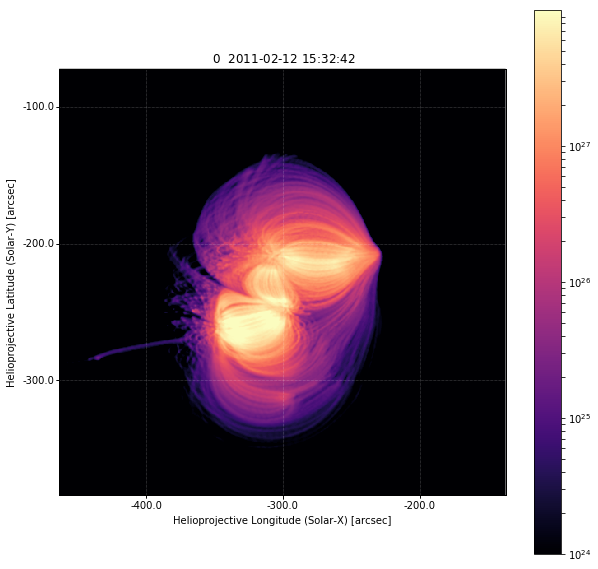

In [211]:
em_total = em_high.total_emission
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=em_total)
em_total.plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1e24,vmax=1e28),cmap='magma')
plt.colorbar()

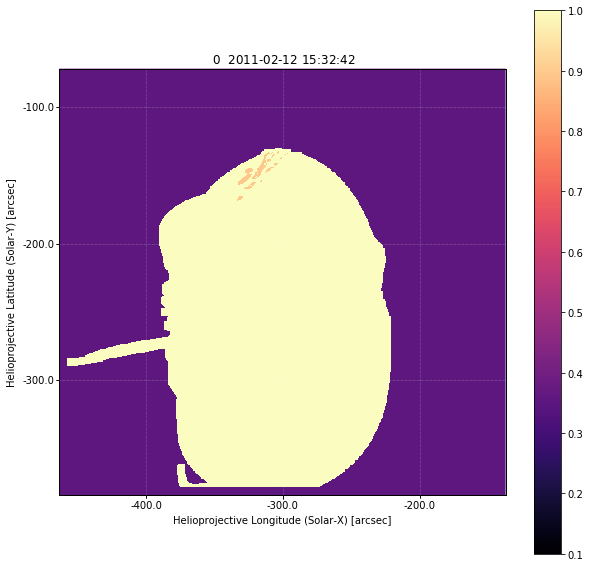

In [234]:
ax = plt.figure(figsize=(10,10)).gca(projection=foo)
foo.plot(vmin=0.1,vmax=1,cmap='magma',axes=ax)
plt.colorbar()

(100.0, 50000.0)

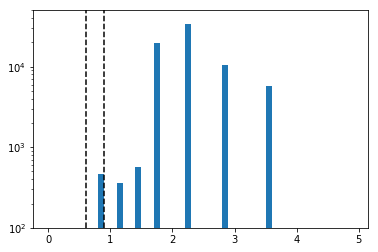

In [273]:
foo = Map(em_high.temperature_bin_centers[em_high.as_array().argmax(axis=2)].to(u.MK).value,em_high[0].meta)
plt.hist(foo.data[em_high.total_emission.data>1e24].flatten(),bins=np.arange(0,5,0.1),log=True);
plt.axvline(x=0.6,color='k',ls='--')
plt.axvline(x=0.9,color='k',ls='--')
plt.ylim(1e2,5e4)

In [337]:
slope_map,rsquared_map = make_slope_map(
    em_high,
    em_threshold=1e24*(u.cm**(-5)),
    temperature_lower_bound=8e5*u.K,
)
slope_map.save(emslope_file_format.format('high_frequency'),overwrite=True)
rsquared_map.save(rsquared_file_format.format('high_frequency'),overwrite=True)

/storage-home/w/wtb2/anaconda3/envs/synthetic-observables/lib/python3.6/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in double_scalars


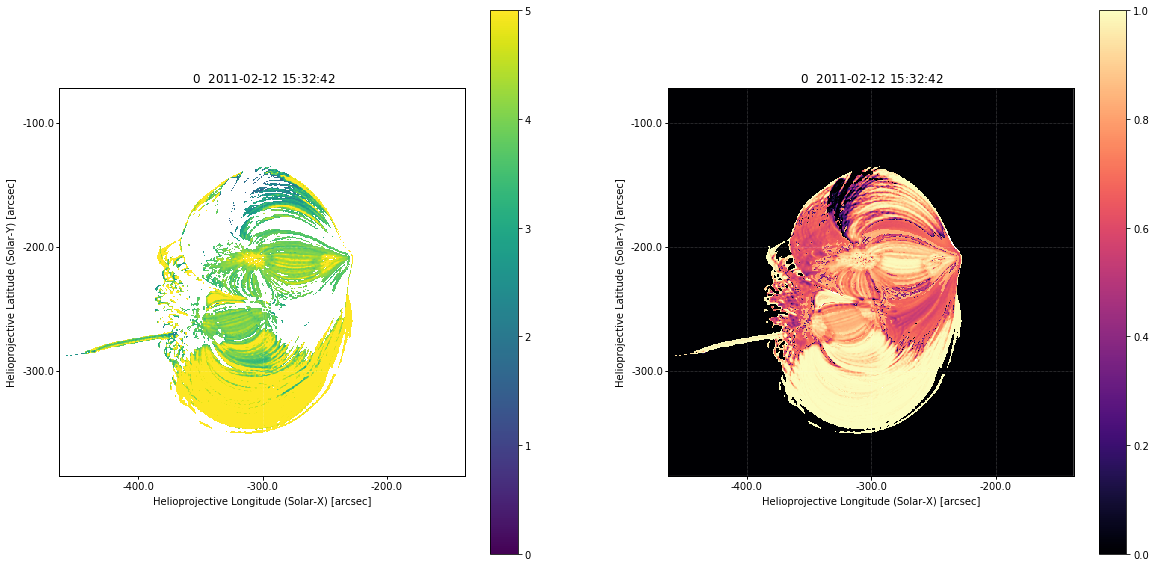

In [338]:
fig = plt.figure(figsize=(20,10))
sm = Map(slope_map.data, slope_map.meta, mask=rsquared_map.data < 0.75)
#sm = sm.submap(
#    
#)
ax = fig.add_subplot(121,projection=sm)
sm.plot(axes=ax,cmap='viridis',vmin=0,vmax=5)
plt.colorbar()
sm = rsquared_map
ax = fig.add_subplot(122,projection=sm)
sm.plot(axes=ax,cmap='magma',vmin=0,vmax=1)
plt.colorbar()

(0.5, 8)

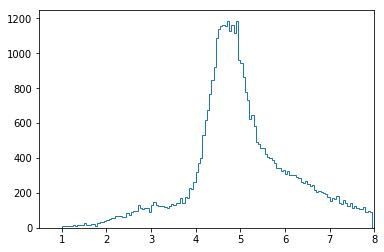

In [311]:
plt.hist(slope_map.data[rsquared_map.data > 0.75].flatten(),bins=np.arange(1,8,0.05),histtype='step');
plt.xlim(0.5,8)

3.4567553460305223
[0.94374299]


(316227.7660168379, 10000000)

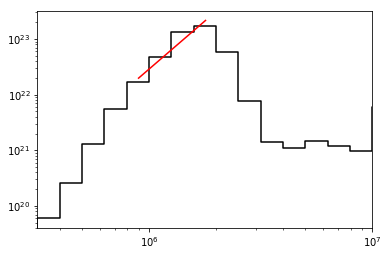

In [198]:
em1d = em_high.get_1d_distribution(
    SkyCoord(Tx=-300*u.arcsec,Ty=-350*u.arcsec,frame=em_high[0].coordinate_frame),
    SkyCoord(Tx=-299*u.arcsec,Ty=-349*u.arcsec,frame=em_high[0].coordinate_frame)
)
index_temperature_bounds = np.where(np.logical_and(
    temperature_bin_centers >= temperature_bin_centers[np.argmax(em1d)-3],
    temperature_bin_centers <= temperature_bin_centers[np.argmax(em1d)]))
temperature_fit = np.log10(
    temperature_bin_centers[index_temperature_bounds].to(u.K).value)
em_fit = np.log10(em1d[index_temperature_bounds].value)
em_fit[np.logical_or(np.isinf(em_fit), np.isnan(em_fit))] = 0.0 
coeff,rss,_,_,_ = np.polyfit(temperature_fit, em_fit, 1,full=True,w=np.where(em_fit>0,1,0))
_,rss_flat,_,_,_ = np.polyfit(temperature_fit, em_fit, 0,full=True,w=np.where(em_fit>0,1,0))
print(coeff[0])
print(1 - rss/rss_flat)
ax = plt.figure().gca()
hist_step(ax,em1d.value,temperature_bin_edges.value,color='k')
ax.plot(10**temperature_fit,(10**coeff[1])*(10**temperature_fit)**coeff[0],color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10**5.5,10**7)
#plt.ylim(1e23,1e26)

## Intermediate 

In [169]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(
    [intensity_file_format.format('intermediate_frequency', c['name'], i) for i in range(500,2500)]) for c in aia.channels])

In [170]:
maps = [cube[c['name']].average() for c in aia.channels]

In [171]:
hk_model = HannahKontarModel(
    maps,
    temperature_bin_edges,
    responses,
    dem_path='/storage-home/w/wtb2/codes/demreg/idl'
)

In [172]:
em_intermediate = hk_model.fit(
    alpha=1,
    increase_alpha=1.1,
    verbose=False,
    n_sample=len(cube[0].maps)
)

In [339]:
slope_map,rsquared_map = make_slope_map(
    em_intermediate,
    em_threshold=1e24*(u.cm**(-5)),
    temperature_lower_bound=8e5*u.K,
)
slope_map.save(emslope_file_format.format('intermediate_frequency'),overwrite=True)
rsquared_map.save(rsquared_file_format.format('intermediate_frequency'),overwrite=True)

/storage-home/w/wtb2/anaconda3/envs/synthetic-observables/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log10
/storage-home/w/wtb2/anaconda3/envs/synthetic-observables/lib/python3.6/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in double_scalars


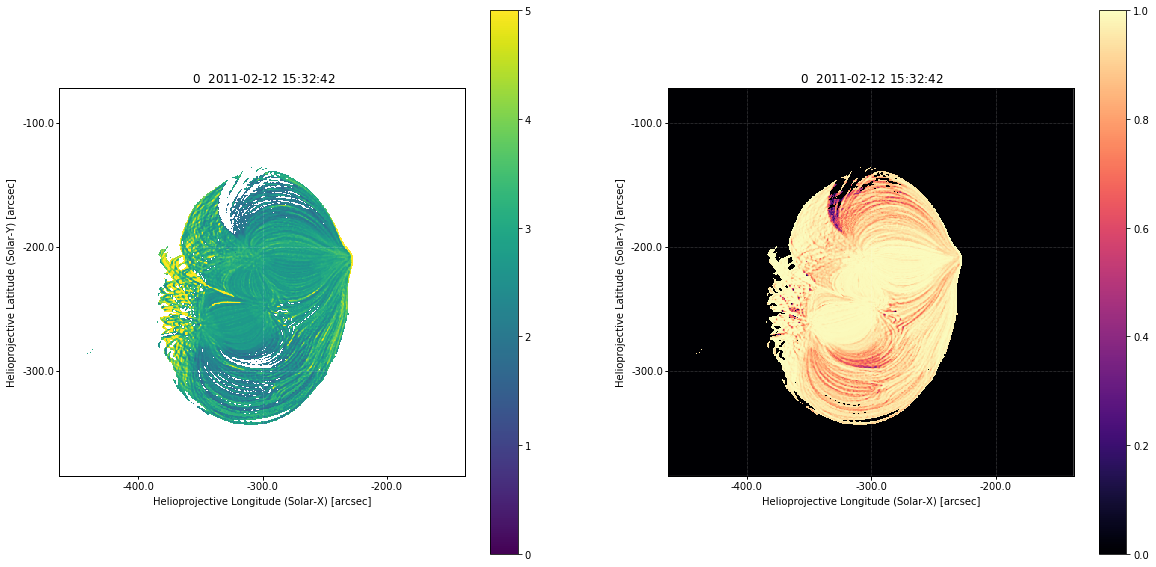

In [340]:
fig = plt.figure(figsize=(20,10))
sm = Map(slope_map.data, slope_map.meta, 
         mask=rsquared_map.data < 0.75
        )
#sm = sm.submap(
#    
#)
ax = fig.add_subplot(121,projection=sm)
sm.plot(axes=ax,cmap='viridis',vmin=0,vmax=5)
plt.colorbar()
sm = rsquared_map
ax = fig.add_subplot(122,projection=sm)
sm.plot(axes=ax,cmap='magma',vmin=0,vmax=1)
plt.colorbar()

(0, 7.5)

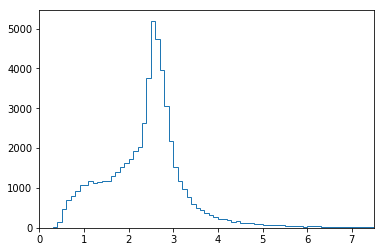

In [330]:
plt.hist(slope_map.data[rsquared_map.data > 0.75].flatten(),bins=np.arange(0,8,0.1),histtype='step');
plt.xlim(0,7.5)

## Low

In [173]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(
    [intensity_file_format.format('low_frequency', c['name'], i) for i in range(500,2500)]) for c in aia.channels])

In [174]:
maps = [cube[c['name']].average() for c in aia.channels]

In [175]:
hk_model = HannahKontarModel(
    maps,
    temperature_bin_edges,
    responses,
    dem_path='/storage-home/w/wtb2/codes/demreg/idl'
)

In [176]:
em_low = hk_model.fit(
    alpha=1,
    increase_alpha=1.1,
    verbose=False,
    n_sample=len(cube[0].maps)
)

In [341]:
slope_map,rsquared_map = make_slope_map(
    em_low,
    em_threshold=1e24*(u.cm**(-5)),
    temperature_lower_bound=8e5*u.K,
)
slope_map.save(emslope_file_format.format('low_frequency'),overwrite=True)
rsquared_map.save(rsquared_file_format.format('low_frequency'),overwrite=True)

/storage-home/w/wtb2/anaconda3/envs/synthetic-observables/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log10


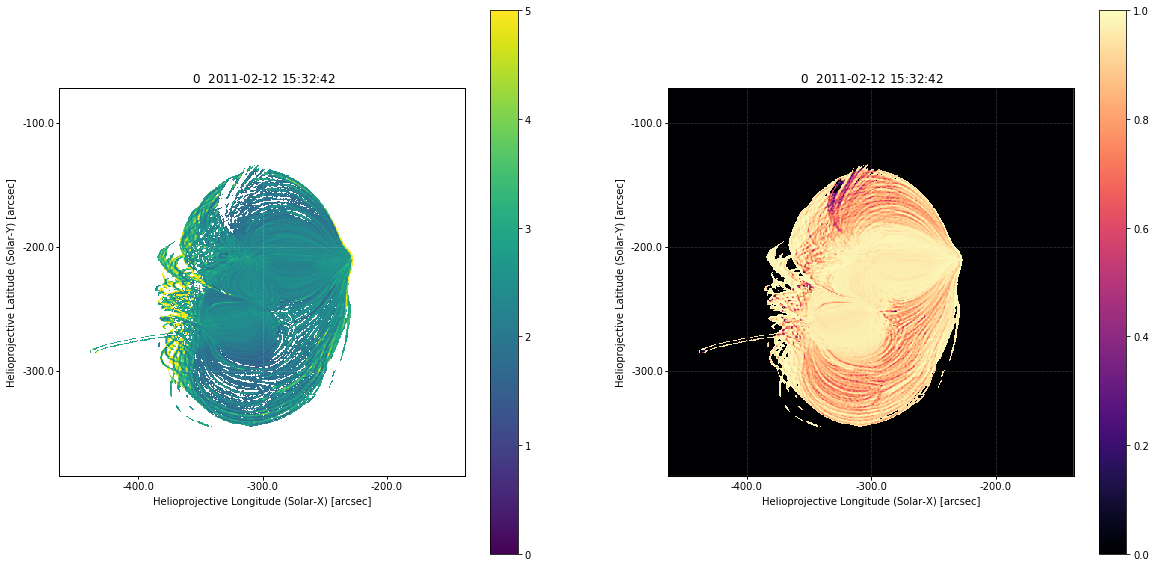

In [342]:
fig = plt.figure(figsize=(20,10))
sm = Map(slope_map.data, slope_map.meta, 
         mask=rsquared_map.data < 0.75
        )
#sm = sm.submap(
#    
#)
ax = fig.add_subplot(121,projection=sm)
sm.plot(axes=ax,cmap='viridis',vmin=0,vmax=5)
plt.colorbar()
sm = rsquared_map
ax = fig.add_subplot(122,projection=sm)
sm.plot(axes=ax,cmap='magma',vmin=0,vmax=1)
plt.colorbar()

(0, 7.5)

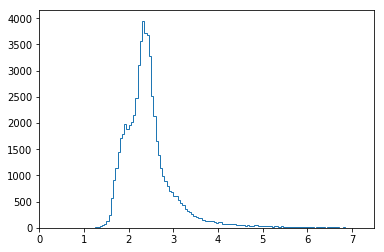

In [343]:
plt.hist(slope_map.data[rsquared_map.data > 0.75].flatten(),bins=np.arange(0,7,0.05),histtype='step');
plt.xlim(0,7.5)